In [1]:
import pandas as pd
df = pd.read_csv('preprocessed_data.csv')
df.head()

,perprocessed,job_category
0,an experienced hr professional hr mentor coach...,hr
1,head talent acquisition hr leader strategic pa...,hr
2,a talent acquisition hr professional experienc...,hr
3,over 18 years experience it ites bpo leading g...,hr
4,human resources business partner demonstrated ...,hr


In [5]:
df['category_id'] = df['job_category'].factorize()[0]
category_id_df = df[['job_category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'job_category']].values)
df.head()

,perprocessed,job_category,category_id
0,an experienced hr professional hr mentor coach...,hr,0
1,head talent acquisition hr leader strategic pa...,hr,0
2,a talent acquisition hr professional experienc...,hr,0
3,over 18 years experience it ites bpo leading g...,hr,0
4,human resources business partner demonstrated ...,hr,0


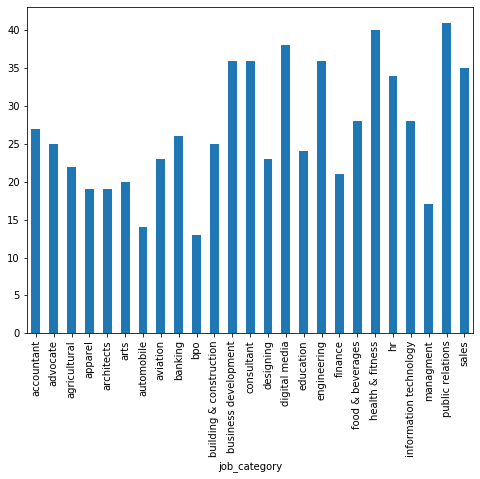

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('job_category').perprocessed.count().plot.bar(ylim=0)
plt.show()

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.perprocessed).toarray()
labels = df.category_id
features.shape

(670, 549)

670 descriptions is explained by 549 features

In [10]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for perprocessed, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(perprocessed))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'accountant':
  . Most correlated unigrams:
. accounting
. tax
  . Most correlated bigrams:
. professional graduated
. 11 years
# 'advocate':
  . Most correlated unigrams:
. laws
. legal
  . Most correlated bigrams:
. experience field
. real estate
# 'agricultural':
  . Most correlated unigrams:
. agriculture
. agricultural
  . Most correlated bigrams:
. 20 years
. experience field
# 'apparel':
  . Most correlated unigrams:
. textile
. apparel
  . Most correlated bigrams:
. team management
. customer service
# 'architects':
  . Most correlated unigrams:
. architects
. architecture
  . Most correlated bigrams:
. experience field
. currently working
# 'arts':
  . Most correlated unigrams:
. art
. arts
  . Most correlated bigrams:
. services industry
. project management
# 'automobile':
  . Most correlated unigrams:
. largest
. automobile
  . Most correlated bigrams:
. mechanical engineering
. vice president
# 'aviation':
  . Most correlated unigrams:
. ideas
. aviation
  . Most correla

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['perprocessed'], df['job_category'], random_state = 0,stratify = df['job_category'])
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [14]:
print(clf.predict(count_vect.transform(["head talent acquisition hr leader strategic partner business leadership team areas people processand structure worked best it services product organizations see"])))

['hr']


In [15]:
df[df['perprocessed'] == "head talent acquisition hr leader strategic partner business leadership team areas people processand structure worked best it services product organizations see"]

,perprocessed,job_category,category_id
1,head talent acquisition hr leader strategic pa...,hr,0


In [22]:
from sklearn.svm import SVC
#from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier as rm
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

C:\Users\dhank\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\dhank\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\dhank\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


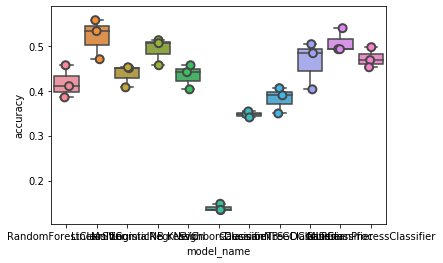

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

CV = StratifiedKFold(n_splits=3)
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    SVC(),
    KNeighborsClassifier(),
    GaussianNB(),
    DecisionTreeClassifier(),
    SGDClassifier(),
    MLPClassifier(),
    GaussianProcessClassifier()
]
#CV = 5
cv_df = pd.DataFrame(index=range(3 * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [24]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.410714
1,RandomForestClassifier,1,0.457399
2,RandomForestClassifier,2,0.385650
3,LinearSVC,0,0.558036
4,LinearSVC,1,0.533632
5,LinearSVC,2,0.470852
6,MultinomialNB,0,0.450893
7,MultinomialNB,1,0.452915
8,MultinomialNB,2,0.408072
9,LogisticRegression,0,0.513393
